<a href="https://colab.research.google.com/github/codefupanda/kaggle-projects/blob/master/siim-isic-melanoma-classification-ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
#!pip uninstall -y tensorflow tensorflow-gpu

In [ ]:
#!pip install -y tensorflow-gpu

In [1]:
pip install -U efficientnet

## Imports

In [2]:
# The basics
import numpy as np
import pandas as pd

# Some plotting
import plotly.graph_objects as go
import plotly.express as px

#sklear
import sklearn
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight

## Keras
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet152V2

# efficientnet
import efficientnet.tfkeras as efn 

# Etc
import os
import shutil
import collections

## Utils

In [3]:
def gdrive_mount():
  from google.colab import drive
  drive.mount('/content/gdrive')

In [4]:
def is_gpu():
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    return False
  print('Found GPU at: {}'.format(device_name))
  return True

In [5]:
class Kaggle:

  def __init__(self, competition_name=None, dataset_name=None, kaggle_config_dir='/content/gdrive/My Drive/Colab Notebooks/.kaggle', base_folder='/tmp'):
    if competition_name:
      self.name = competition_name
      self.competition = True
    if dataset_name:
      self.name = dataset_name
      self.dataset = True 
    self.kaggle_config_dir = kaggle_config_dir
    self.base_folder = base_folder
    self.path = os.path.join(self.base_folder, self.name)
    os.environ['KAGGLE_CONFIG_DIR'] = kaggle_config_dir

  def download(self):
    if self.dataset:
      return os.system('kaggle datasets download -d ' + self.name + ' -p ' + self.path)
    return os.system('kaggle competitions download -c ' + self.name + ' -p ' + self.path)

  def download_file(self, file_name, sub_folder=''):
    if self.dataset:
      return os.system('kaggle datasets download -d ' + self.name + ' -p ' + os.path.join(self.path, sub_folder) + ' -f ' + file_name)
    return os.system('kaggle competitions download -c ' + self.name + ' -p ' + os.path.join(self.path, sub_folder) + ' -f ' + file_name)

  def show_files(self):
    return print(self.get_files())

  def get_files(self, sub_folder=''):
    return [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.join(self.path, sub_folder)) for f in fn]

  def show_dirs(self):
    return print(self.get_dirs())

  def get_dirs(self):
    return [ name for name in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, name)) ]

  def unzip(self):
    return os.system('find ' + self.path + ' -name "*.zip" | xargs -P 5 -I fileName sh -c \'unzip -o -d "$(dirname "fileName")" "fileName"\'')

  def clean_folder(self, file_extension='.zip'):
    for f1le in self.get_files():
      if f1le.endswith(file_extension):
        os.remove(f1le)

  def reset_folder(self):
    shutil.rmtree(self.path)

In [6]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn import model_selection

class ImageClassifier:

  METRICS = [
    metrics.TruePositives(name='tp'),
    metrics.FalsePositives(name='fp'),
    metrics.TrueNegatives(name='tn'),
    metrics.FalseNegatives(name='fn'), 
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
  ]

  def __init__(self, base_folder, train_df, batch_size=1024, metrics=None, image_shape=(256, 256, 3), completion_callback=None):
    self.base_folder = base_folder
    self.batch_size = batch_size
    self.train_df = train_df
    self.metrics = metrics or ImageClassifier.METRICS
    self.results = list()
    self.image_shape = image_shape
    self.completion_callback = completion_callback

  def train(self, model_def, epochs, k_folds=None, class_weight=None, ):
    """
      model_def: function or collection of functions
      epochs: epochs for NN
      k_folds: mandatory if model_def is fun, if model_def is Iterable, k_folds = len(model_def)
    """
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, fill_mode='nearest', height_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
    val_datagen = ImageDataGenerator(rescale=1./255)
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=3, mode='max', restore_best_weights=True)

    if class_weight is None:
      class_weight_array = compute_class_weight('balanced', np.unique(self.train_df['target']), self.train_df['target'])
      class_weight = {i : class_weight_array[i] for i in range(len(class_weight_array))}
      print('computed class weights ' + str(class_weight))

    models = []
    if isinstance(model_def, collections.Iterable):
      models = [model_def_() for model_def_ in model_def]
      k_folds = len(models)
    else:
      models = [model_def() for i in range(k_folds)]

    i = 0
    skf = model_selection.StratifiedKFold(n_splits=k_folds)
    for train_index, test_index in skf.split(self.train_df['image_id_ext'], self.train_df['target']):
      model = models[i]
      i = i + 1
      train_generator = train_datagen.flow_from_dataframe(self.train_df.iloc[train_index], 
                                                      x_col="image_id_ext",
                                                      y_col="target",
                                                      directory=self.base_folder + '/train/', 
                                                      target_size=self.image_shape[0:2], 
                                                      batch_size=self.batch_size,
                                                      class_mode='raw',
                                                      validate_filenames=False,)
      test_generator = train_datagen.flow_from_dataframe(self.train_df.iloc[test_index], 
                                                      x_col="image_id_ext",
                                                      y_col="target",
                                                      directory=self.base_folder + '/train/', 
                                                      target_size=self.image_shape[0:2], 
                                                      batch_size=self.batch_size,
                                                      class_mode='raw',
                                                      validate_filenames=False,
                                                      shuffle=False)

      history = model.fit_generator(train_generator, 
                                  steps_per_epoch=len(train_index)//self.batch_size,
                                  epochs=epochs,
                                  class_weight=class_weight,
                                  #callbacks = [early_stopping],
                                  validation_data=test_generator,
                                  validation_steps=len(test_index)//self.batch_size,
                                  )
      self.results.append({'model': model, 'history': history})
      if self.completion_callback:
        self.completion_callback({'model': model, 'history': history})
    return self.results


  def test(self, test_df, batch_size):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                      x_col="image_id_ext",
                                                      y_col="target",
                                                      directory=self.base_folder + '/test/', 
                                                      target_size=self.image_shape[0:2], 
                                                      batch_size=batch_size,
                                                      class_mode='raw',
                                                      validate_filenames=False,
                                                      shuffle=False)
    probs = np.zeros(len(test_df))
    for result in self.results:
        model = result['model']
        model_probs = model.predict_generator(test_generator, len(test_df)//batch_size, verbose=1)
        probs = probs + model_probs.reshape(len(test_df))

    return probs / len(self.results)



In [7]:
# https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = tf.keras.backend.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = tf.keras.backend.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = tf.keras.backend.clip(pt_0, epsilon, 1. - epsilon)

        return -tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.keras.backend.log(pt_1)) \
               -tf.keras.backend.mean((1 - alpha) * tf.keras.backend.pow(pt_0, gamma) * tf.keras.backend.log(1. - pt_0))

    return binary_focal_loss_fixed

## Setup the environment

In [8]:
gdrive_mount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Download data

In [9]:
kaggle = Kaggle(dataset_name='shonenkov/melanoma-merged-external-data-512x512-jpeg')

In [10]:
kaggle.download()
kaggle.unzip()
kaggle.clean_folder()

In [11]:
!mkdir '/tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/train'
!mkdir '/tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/test'

In [12]:
kaggle.show_dirs()

['512x512-test', 'train', '512x512-dataset-melanoma', 'test']


In [13]:
!find /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/ -type f -print0 | xargs -0 mv -t /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/train/

In [14]:
!mv /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/512x512-test/512x512-test/* /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/test

In [15]:
!ls /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/train/ | wc -l

60487


In [16]:
!ls /tmp/shonenkov/melanoma-merged-external-data-512x512-jpeg/test/ | wc -l

10982


In [17]:
train_df = pd.read_csv(os.path.join(kaggle.path, 'marking.csv'))

In [18]:
train_df.shape

(60487, 7)

In [19]:
train_df.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity


In [20]:
# imbalanced data
train_df['target'].value_counts()

0    55008
1     5479
Name: target, dtype: int64

In [21]:
train_df['image_id_ext'] = train_df['image_id'] + '.jpg'

In [39]:
def model_def1():
  print('creating model model_def1')
  sgd = optimizers.Adam(learning_rate=0.001)

  conv_base = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  conv_base.trainable = False
  
  for layer in conv_base.layers:
    layer.trainable = False
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=ImageClassifier.METRICS)
  return model

In [40]:
def model_def2():
  print('creating model model_def2')
  sgd = optimizers.Adam(learning_rate=0.001)

  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  conv_base.trainable = False
  
  for layer in conv_base.layers:
    layer.trainable = False
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=ImageClassifier.METRICS)
  return model

In [41]:
def model_def3():
  print('creating model model_def3')
  sgd = optimizers.Adam(learning_rate=0.001)

  conv_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  conv_base.trainable = False
  
  for layer in conv_base.layers:
    layer.trainable = False
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=ImageClassifier.METRICS)
  return model

# Prep the mode

In [25]:
original_train_df = train_df

In [26]:
#train_df = original_train_df

In [27]:
#train_df = pd.concat([original_train_df[original_train_df['target'] == 1], original_train_df[original_train_df['target'] == 0].sample(len(original_train_df[original_train_df['target'] == 1]))])

In [28]:
train_df.shape, train_df[train_df['target'] == 1].shape, train_df[train_df['target'] == 0].shape 

((60487, 8), (5479, 8), (55008, 8))

In [29]:
#train_df = train_df.sample(128*2)

In [30]:
#len(train_df[train_df['target'] == 1])

In [31]:
def save_model(res_model): 
  model = res_model['model']
  model.save('/content/gdrive/My Drive/Colab Notebooks/.kaggle/siim-isic-melanoma-classification/revisit_final_ensemble.h5')

In [42]:
classifier = ImageClassifier(kaggle.path, train_df, batch_size=256, completion_callback=save_model)

In [43]:
result = classifier.train([model_def1, model_def2, model_def3], 2, class_weight = {0: 1, 1: 8})

creating model model_def1
creating model model_def2
58892288/58889256 [==============================] - 0s 0us/step
creating model model_def3
234553344/234545216 [==============================] - 4s 0us/step
Found 40324 non-validated image filenames.
Found 20163 non-validated image filenames.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
157/157 [==============================] - 1324s 8s/step - loss: 2.5344 - tp: 2431.0000 - fp: 9085.0000 - tn: 27351.0000 - fn: 1201.0000 - accuracy: 0.7433 - precision: 0.2111 - recall: 0.6693 - auc: 0.7718 - val_loss: 1.1115 - val_tp: 518.0000 - val_fp: 697.0000 - val_tn: 17639.0000 - val_fn: 1114.0000 - val_accuracy: 0.9093 - val_precision: 0.4263 - val_recall: 0.3174 - val_auc: 0.8254
Epoch 2/2
157/157 [==============================] - 1261s 8s/step - loss: 1.5368 - tp: 2635.0000 - fp: 7557.0000 - tn: 28875.0000 - fn: 1001.0000 - accuracy: 0.7864 - precision: 0.2585 - recall: 0.7247 - auc: 0.8429 - val_loss

In [44]:
i = 1
for res_model in classifier.results:
  model = res_model['model']
  model.save('/content/gdrive/My Drive/Colab Notebooks/.kaggle/siim-isic-melanoma-classification/revisit_final_ensemble' + str(i) +'.h5')
  i = i + 1

# Test

In [45]:
test_images = kaggle.get_files('test')

In [46]:
test_image_ext = [os.path.split(test_image)[1] for test_image in test_images]

In [47]:
test_df = pd.DataFrame({'image_id_ext': test_image_ext})

In [48]:
len(test_df)

10982

In [49]:
test_df['target'] = 0

In [50]:
test_df.head()

,image_id_ext,target
0,ISIC_2827942.jpg,0
1,ISIC_3293577.jpg,0
2,ISIC_1105085.jpg,0
3,ISIC_8517129.jpg,0
4,ISIC_6185319.jpg,0


In [51]:
probs = classifier.test(test_df, 38)

Found 10982 non-validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.
289/289 [==============================] - 219s 757ms/step


In [59]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                  x_col="image_id_ext",
                                                  y_col="target",
                                                  directory=kaggle.path + '/test/', 
                                                  target_size=classifier.image_shape[0:2], 
                                                  batch_size=38,
                                                  class_mode='raw',
                                                  validate_filenames=False,
                                                  shuffle=False)
probs = np.zeros(len(test_df))
for result in classifier.results:
    model = result['model']
    model_probs = model.predict_generator(test_generator, len(test_df)//38, verbose=1)
    probs = probs + model_probs.reshape(len(test_df))

probs = probs / 3

Found 10982 non-validated image filenames.
289/289 [==============================] - 219s 757ms/step


In [60]:
test_df['target'] = probs

In [61]:
test_df['image_name'] = [sds[0] for sds in test_df['image_id_ext'].str.split(".")]

In [62]:
test_df[['image_name', 'target']].to_csv('/content/gdrive/My Drive/Colab Notebooks/.kaggle/siim-isic-melanoma-classification/revisit_final_ensemble_result.csv', index=False)

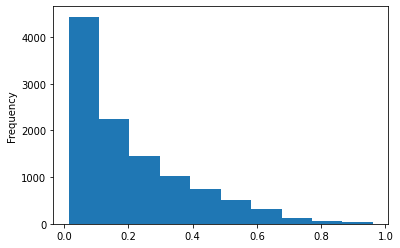

In [63]:
test_df['target'].plot.hist(10)

In [64]:
from google.colab import files
files.download('/content/gdrive/My Drive/Colab Notebooks/.kaggle/siim-isic-melanoma-classification/revisit_final_ensemble_result.csv')